In [1]:
# copied from tasks #1

import numpy as np
import os

def write_data(filename, num_vars, num_constants, min_rand, max_rand, num_data_points, results, *vars):
    vars = list(zip(*vars)) # vars = vars.T

    with open(filename, "w") as file:
        file.write(f"{num_vars} {num_constants} {min_rand} {max_rand} {num_data_points}\n")
        for i in range(num_data_points):
            file.write(" ".join([str(v) for v in vars[i]]))
            file.write(f" {results[i]}\n")

def gen_data(f, domain, num_data_points=100, num_constants=100):
    n_args = f.__code__.co_argcount
    vars = [np.random.uniform(*domain, num_data_points) for _ in range(n_args)]
    results = [f(*v) for v in zip(*vars)]
    filename = f".dat/{f.__name__}_{domain[0]}_{domain[1]}.dat"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    write_data(filename, n_args, num_constants, domain[0], domain[1], num_data_points, results, *vars)

def load_data_points(filename) -> tuple[np.ndarray, np.ndarray]:
    with open(filename) as file:
        data = np.loadtxt(file, skiprows=1)
        return data[:, :-1], data[:, -1]

Evolving .dat/f1_0_100.dat...
	expression: (((((cos(58.00) + X1) + X1) + X1) + (X1 + X1)) * ((cos(((9.07 / (((((69.04 - 3.14) / 8.03) + 43.65) * 76.13) / (cos(((38.66 * 76.13) - 31.65)) / ((57.10 + ((19.60 + 57.10) + 95.09)) + (99.82 + ((((cos((75.25 * 1.11)) + (cos((36.52 + (cos(59.43) / 15.10))) + X1)) * X1) * 78.29) / 15.87)))))) + 96.25)) + X1) * X1))
	fitness: -3127.9557118939174
Evolving .dat/f2_-3.14_3.14.dat...
	expression: (cos(X1) + sin(X1))
	fitness: -0.0
Evolving .dat/f3_0_4.dat...
	expression: ((X1 - (cos(sin(((sin((0.63 * 0.60)) * 0.63) + ((X1 * 0.63) + 0.19)))) * 0.37)) + (sin(((X1 - (cos(((sin(X1) * (X1 - (cos(((0.22 + 0.22) / (cos(sin((X1 + cos(((((0.37 * 0.63) + X1) - (cos((sin(0.37) * 0.63)) * 0.22)) / 3.90))))) * 0.22))) * 0.37))) / X1)) * 0.37)) + cos(((X1 + 0.37) / 2.91)))) * 0.63))
	fitness: -0.7711674977854042


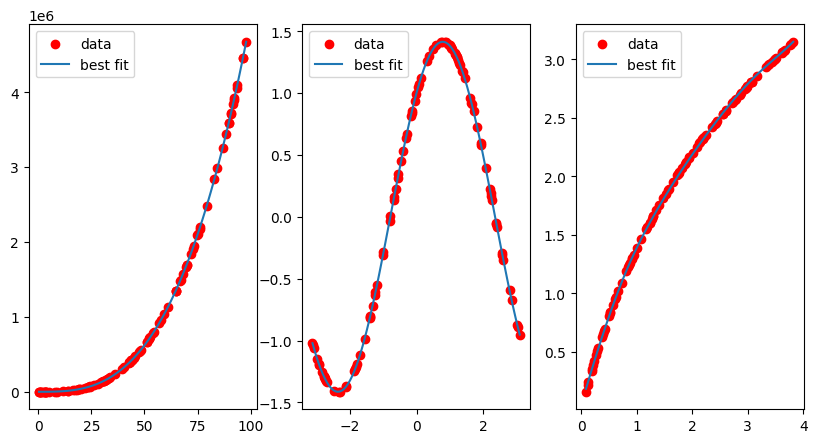

In [2]:
# regressions from set 1 with sin/cos
from tiny_gp import TinyGP
from numpy import sin, cos
import matplotlib.pyplot as plt

FILENAMES = [
    ".dat/f1_0_100.dat",
    ".dat/f2_-3.14_3.14.dat",
    ".dat/f3_0_4.dat",
]
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

for i, filename in enumerate(FILENAMES):
    print(f"Evolving {filename}...")

    # 2. symbolic regression for different functions
    tgp = TinyGP(filename)
    for _ in range(20):
        tgp.evolve()
        if tgp.fitness(tgp.best()) > -1e-3:
            break

    print(f"\texpression: {tgp.str(tgp.best())}")
    print(f"\tfitness: {tgp.fitness(tgp.best())}")
    best_exp = tgp.str(tgp.best(), 5) # higher precision for eval

    # 4. comparison plots
    X, y = load_data_points(filename)
    x = np.linspace(np.min(X), np.max(X), 100)
    def best_exp_func(X1):
        return eval(best_exp)
    y_pred = [best_exp_func(x_i) for x_i in x]
    axs[i].scatter(X, y, c='red', label='data')
    axs[i].plot(x, y_pred, label='best fit')
    axs[i].legend()

plt.show()

expression: (-0.08 - (cos(X1) + -0.08))
fitness: -5.506012312750386e-15


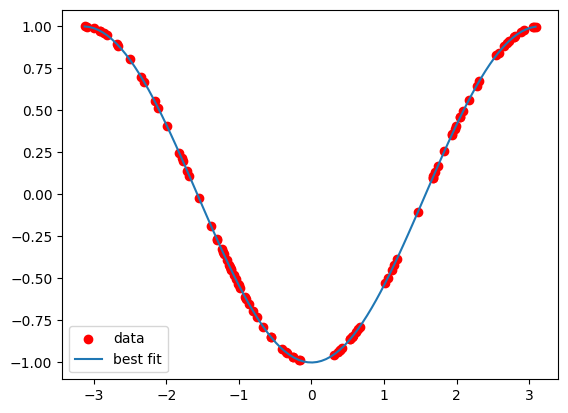

In [3]:
# perform symbolic regression for function sin(x + 3.141592/2) in sine domain

from tiny_gp import TinyGP
import matplotlib.pyplot as plt
from numpy import sin, cos

def f_sin(x):
    return np.sin(x - np.pi/2)

gen_data(f_sin, (-3.14, 3.14))

# symbolic regression
tgp = TinyGP(".dat/f_sin_-3.14_3.14.dat", pop_size=100000)
for _ in range(20):
    tgp.evolve()
    if tgp.fitness(tgp.best()) > -1e-6:
        break
print(f"expression: {tgp.str(tgp.best())}")
print(f"fitness: {tgp.fitness(tgp.best())}")
best_exp = tgp.str(tgp.best(), 5) # higher precision for eval

# comparison plots
X, y = load_data_points(".dat/f_sin_-3.14_3.14.dat")
x = np.linspace(np.min(X), np.max(X), 100)
def best_exp_func(X1):
    return eval(best_exp)
y_pred = [best_exp_func(x_i) for x_i in x]
plt.scatter(X, y, c='red', label='data')
plt.plot(x, y_pred, label='best fit')
plt.legend()

plt.show()

expression: (((-1.40 * -1.14) / ((((X1 * (-0.95 - 1.00)) / 0.67) * (cos(sin(0.30)) + 0.15)) + 0.94)) - ((((-0.15 - X1) * ((0.62 / (0.15 + 0.94)) + (-0.60 + ((0.22 + 0.10) / (((0.22 * (((((X1 * (-0.95 - 1.00)) / 0.67) * (cos(sin(0.58)) + 0.30)) + 0.94) - (((sin(-0.04) * 0.52) - 0.10) - 0.45))) + -0.09) + (-0.60 + -0.60)))))) + sin((-0.42 + -1.07))) * X1))
fitness: -24.81038934181955


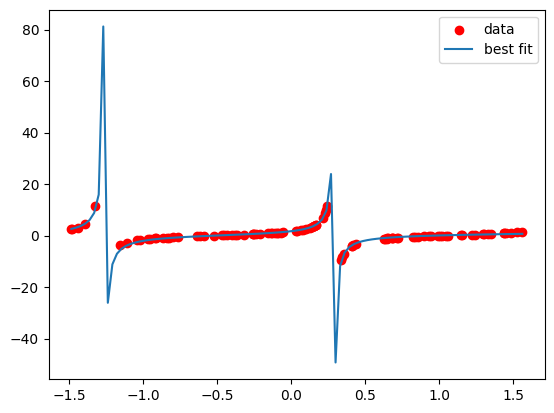

In [4]:
# additionally perform symbolic regression for function tan(2x +1) in tangent domain

from tiny_gp import TinyGP
import matplotlib.pyplot as plt
from numpy import sin, cos

def f_tan(x):
    return np.tan(2*x + 1)

gen_data(f_tan, (-1.57, 1.57))

# symbolic regression
tgp = TinyGP(".dat/f_tan_-1.57_1.57.dat", pop_size=100000)
for _ in range(20):
    tgp.evolve()
    if tgp.fitness(tgp.best()) > -1e-3:
        break
print(f"expression: {tgp.str(tgp.best())}")
print(f"fitness: {tgp.fitness(tgp.best())}")
best_exp = tgp.str(tgp.best(), 5) # higher precision for eval

# comparison plots
X, y = load_data_points(".dat/f_tan_-1.57_1.57.dat")
x = np.linspace(np.min(X), np.max(X), 100)
def best_exp_func(X1):
    return eval(best_exp)
y_pred = [best_exp_func(x_i) for x_i in x]
plt.scatter(X, y, c='red', label='data')
plt.plot(x, y_pred, label='best fit')
plt.legend()

plt.show()

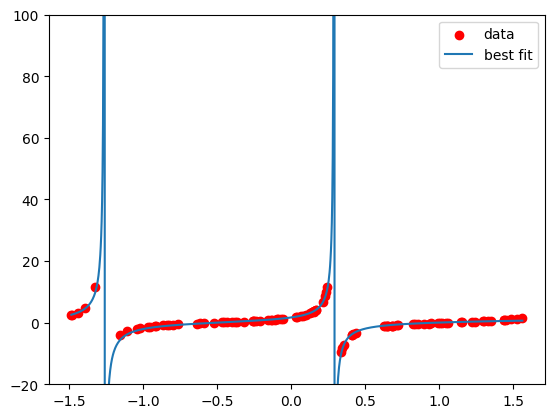

In [5]:
# comparison plots

X, y = load_data_points(".dat/f_tan_-1.57_1.57.dat")
x = np.linspace(np.min(X), np.max(X), 1000)
def best_exp_func(X1):
    return eval(best_exp)
y_pred = [best_exp_func(x_i) for x_i in x]
plt.scatter(X, y, c='red', label='data')
# plt.plot(x, f_tan(x), label='og')
plt.plot(x, y_pred, label='best fit')
plt.ylim((-20, 100))
plt.legend()

plt.show()

In [6]:
# Implement (any technique) an optimizer for TinyGP solutions - the goal is to maximize simplification of solutions. 
# For example, if the solution contains operations on constants (e.g. "1.07 + 2.1/1") it can be simplified (in this case to "3.17")

import re
import math

# formal grammar to better understand the problem:
# expr -> term ([+-] term)*
# term -> factor ([*/] factor)*
# factor -> X\d+ | \d+\.\d+ | (expr) | sin(expr) | cos(expr)

class Parser:
    def __init__(self, tokens):
        self.tokens = tokens
        self.i = 0

    def peek(self, eof_expected_msg=None):
        if self.i >= len(self.tokens):
            if eof_expected_msg:
                raise ValueError(f"Unexpected end of input, missing {eof_expected_msg}")
            else:
                raise ValueError("Unexpected end of input")
        return self.tokens[self.i]

    def consume(self, expected=None):
        token = self.peek(expected)
        if (isinstance(expected, str) and token != expected) or (
            isinstance(expected, list) and token not in expected
        ):
            raise ValueError(f"Expected '{expected}'")
        self.i += 1

    def parse(self):
        result = self.expr()
        if self.i < len(self.tokens):
            raise ValueError(f"Found extra tokens '{''.join(self.tokens[self.i:])}', expected EOF")
        return result

    def expr(self):
        checkpoint = self.i
        try:
            result = self.term()
            while self.i < len(self.tokens) and self.peek("+ or -") in ["+", "-"]:
                op = self.peek()
                self.consume() # consume op
                if op == "+":
                    result = f"{result} + {self.term()}"
                else:
                    result = f"{result} - {self.term()}"

            # If the result does not contain any variables, evaluate it
            if "X" not in result:
                result = eval(result, {"sin": math.sin, "cos": math.cos})
                result = round(result * 1000000) / 1000000
                result = str(result).rstrip("0").rstrip(".")
            
            return result
        except ValueError as e:
            self.i = checkpoint
            raise e
    
    def term(self):
        checkpoint = self.i
        try:
            result = self.factor()
            while self.i < len(self.tokens) and self.peek("* or /") in ["*", "/"]:
                op = self.peek()
                self.consume() # consume op
                if op == "*":
                    result = f"{result} * {self.factor()}"
                else:
                    result = f"{result} / {self.factor()}"

            # If the result does not contain any variables, evaluate it
            if "X" not in result:
                result = eval(result, {"sin": math.sin, "cos": math.cos})
                result = round(result * 1000000) / 1000000
                result = str(result).rstrip("0").rstrip(".")

            return result
        except ValueError as e:
            self.i = checkpoint
            raise e

    def factor(self):
        checkpoint = self.i
        try:
            token = self.peek("variable, constant, parenthesis or a function")
            if token.startswith("X"):
                result = token
                self.consume()
            elif token[0].isdigit() or token[0] == "-" and len(token) > 1 and token[1].isdigit():
                result = token
                self.consume()
            elif token == "(":
                self.consume("(")
                result = f"({self.expr()})"
                self.consume(")")
            elif token == "sin":
                self.consume("sin")
                self.consume("(")
                result = f"sin({self.expr()})"
                self.consume(")")
            elif token == "cos":
                self.consume("cos")
                self.consume("(")
                result = f"cos({self.expr()})"
                self.consume(")")
            else:
                raise ValueError(f"Unexpected token {self.peek()}")
            return result
        except ValueError as e:
            self.i = checkpoint
            raise e

def optimize_exp(exp):
    tokens = re.findall(r"X\d+|-?\d+\.\d+|-?\d+|sin|cos|[\(\)\+\-\*\/]", exp)
    parser = Parser(tokens)
    return parser.parse()


for expr in [
    "1.07 + 2.1/1",
    "sin(3.141592/2)",
    "(((0.23 - 0.23)) - cos(X1))",
    "(cos(cos(((sin((-0.06 / ((0.30 * 0.15) - (sin((sin(sin(0.15))))))))))))) * X1",
    "X1 + 1 + 2 * X1 * 3"
]:
    print(optimize_exp(expr))
    

3.17
1
(0 - cos(X1))
(0.65752) * X1
X1 + 1 + 2 * X1 * 3


expression: (((4843.45 - (7196.82 / X1)) / (X1 - (6608.78 / X1))) - (X1 / ((6608.78 / X1) / (((X1 - ((X1 - -15018.28) / (1865.3))) / ((6608.78 / ((X1 - ((6608.78 - X1) / 4843.45)) / ((-0.440049) / X1))) / X1)) - 8474.08))))
fitness: -406405.941866123


<string>:1: RuntimeWarning: divide by zero encountered in scalar divide
<string>:1: RuntimeWarning: invalid value encountered in scalar divide


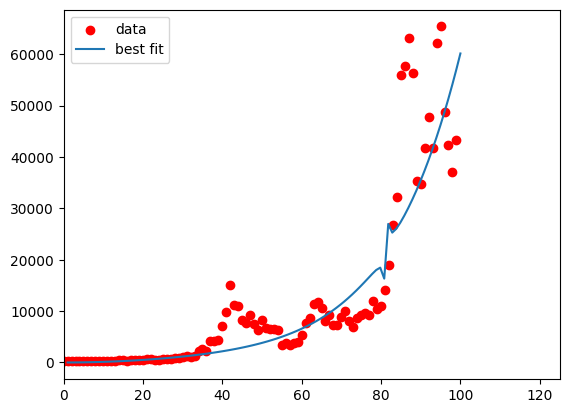

In [7]:
# [Optional] Download any currency rate (e.g. BTC) for example from last 180 days and perform symbolic regression. 
# Check the quality of fit.

import pandas as pd
from tiny_gp import TinyGP

df = pd.read_csv("BTC-Daily.csv")
df = df.sort_values("date")
data = df["open"].to_numpy()
# reduce data resolution to 100 points
data = np.interp(np.linspace(0, len(data), 100), np.arange(len(data)), data)

filename = f".dat/btc.dat"
os.makedirs(os.path.dirname(filename), exist_ok=True)
write_data(filename, 1, 100, -np.std(data), np.std(data), len(data), data, np.arange(len(data)))

# symbolic regression
tgp = TinyGP(".dat/btc.dat", pop_size=10000, prog_size=50, lib_name="tiny_gp_no_sin_cos")
for _ in range(50):
    tgp.evolve()
    if tgp.fitness(tgp.best()) > -1e-3:
        break
print(f"expression: {optimize_exp(tgp.str(tgp.best()))}")
print(f"fitness: {tgp.fitness(tgp.best())}")

# comparison plots
x_lin = np.linspace(0, len(data), 100)
def best_exp_func(X1):
    return eval(tgp.str(tgp.best()))
y_pred = [best_exp_func(x_i) for x_i in x_lin]
plt.scatter(np.arange(len(data)), data, c='red', label='data')
plt.plot(x_lin, y_pred, label='best fit')
plt.xlim(0, len(data) * 1.25)
plt.legend()
plt.show()